In [193]:
pip install statsmodels


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from scipy.signal import periodogram
import statsmodels.api as sm

   id       date    country         store  \
0   0 2017-01-01  Argentina  Kaggle Learn   
1   1 2017-01-01  Argentina  Kaggle Learn   
2   2 2017-01-01  Argentina  Kaggle Learn   
3   3 2017-01-01  Argentina  Kaggle Learn   
4   4 2017-01-01  Argentina  Kaggle Learn   

                                          product  num_sold  
0               Using LLMs to Improve Your Coding        63  
1                   Using LLMs to Train More LLMs        66  
2  Using LLMs to Win Friends and Influence People         9  
3      Using LLMs to Win More Kaggle Competitions        59  
4                      Using LLMs to Write Better        49  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   id        136950 non-null  int64         
 1   date      136950 non-null  datetime64[ns]
 2   country   136950 non-null  object        
 3   store  

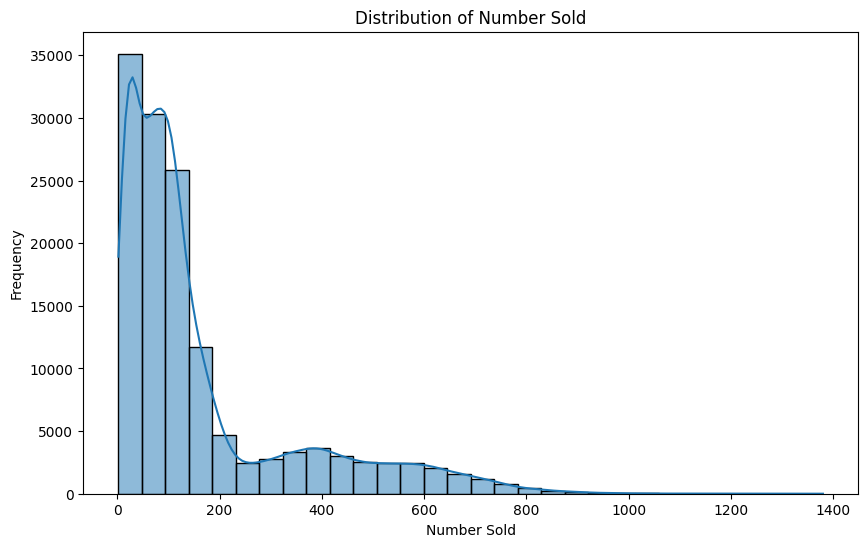

In [195]:
data = pd.read_csv('data.csv', parse_dates=['date'])

print(data.head())
print(data.info())
print(data.describe())

# Выбрасываем нулевые значения
print(data.isnull().sum())

# Выбрасываем дубликатные значения
data = data.drop_duplicates()

# Конвертируем в питоновский формат данных
data['date'] = pd.to_datetime(data['date'])

plt.figure(figsize=(10, 6))
sns.histplot(data['num_sold'], bins=30, kde=True)
plt.title('Distribution of Number Sold')
plt.xlabel('Number Sold')
plt.ylabel('Frequency')
plt.show()

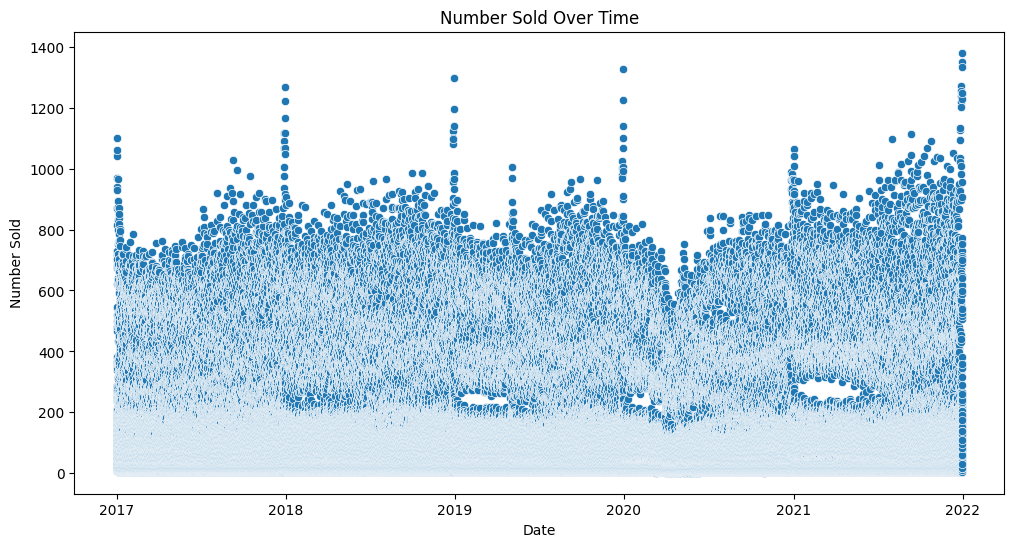

In [196]:
# Смотрим количество проданных по времени
plt.figure(figsize=(12, 6))
sns.scatterplot(x='date', y='num_sold', data=data)
plt.title('Number Sold Over Time')
plt.xlabel('Date')
plt.ylabel('Number Sold')
plt.show()

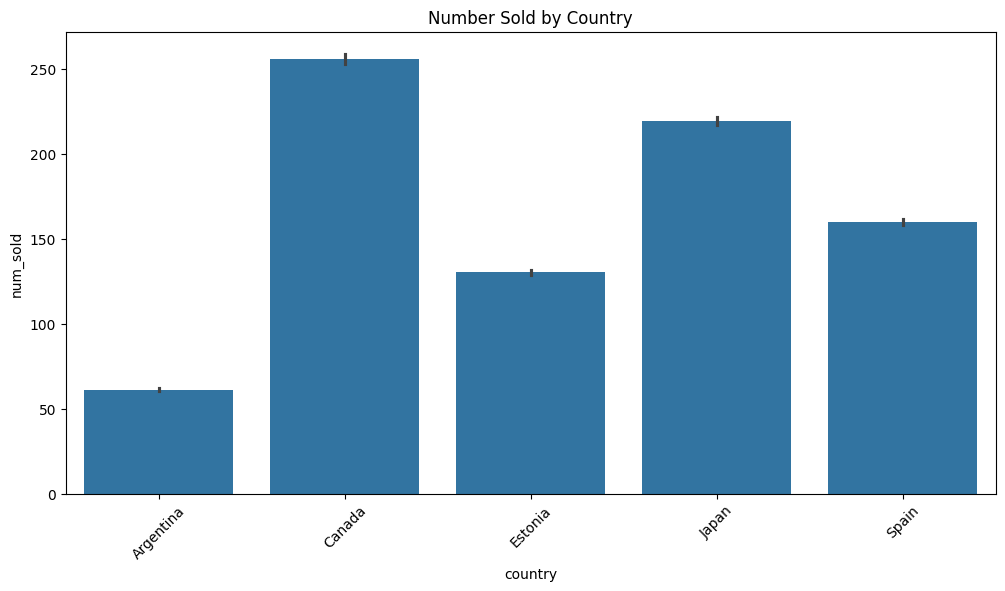

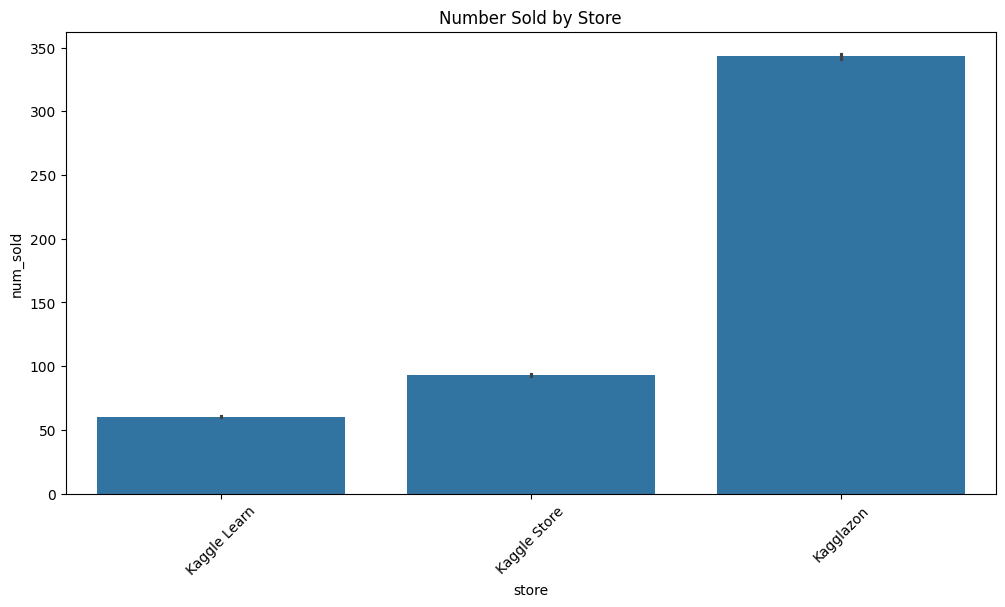

In [197]:
# Количество проданных по стране за все время
plt.figure(figsize=(12, 6))
sns.barplot(x='country', y='num_sold', data=data)
plt.title('Number Sold by Country')
plt.xticks(rotation=45)
plt.show()

# Количество проданных по магазину за все время
plt.figure(figsize=(12, 6))
sns.barplot(x='store', y='num_sold', data=data)
plt.title('Number Sold by Store')
plt.xticks(rotation=45)
plt.show()

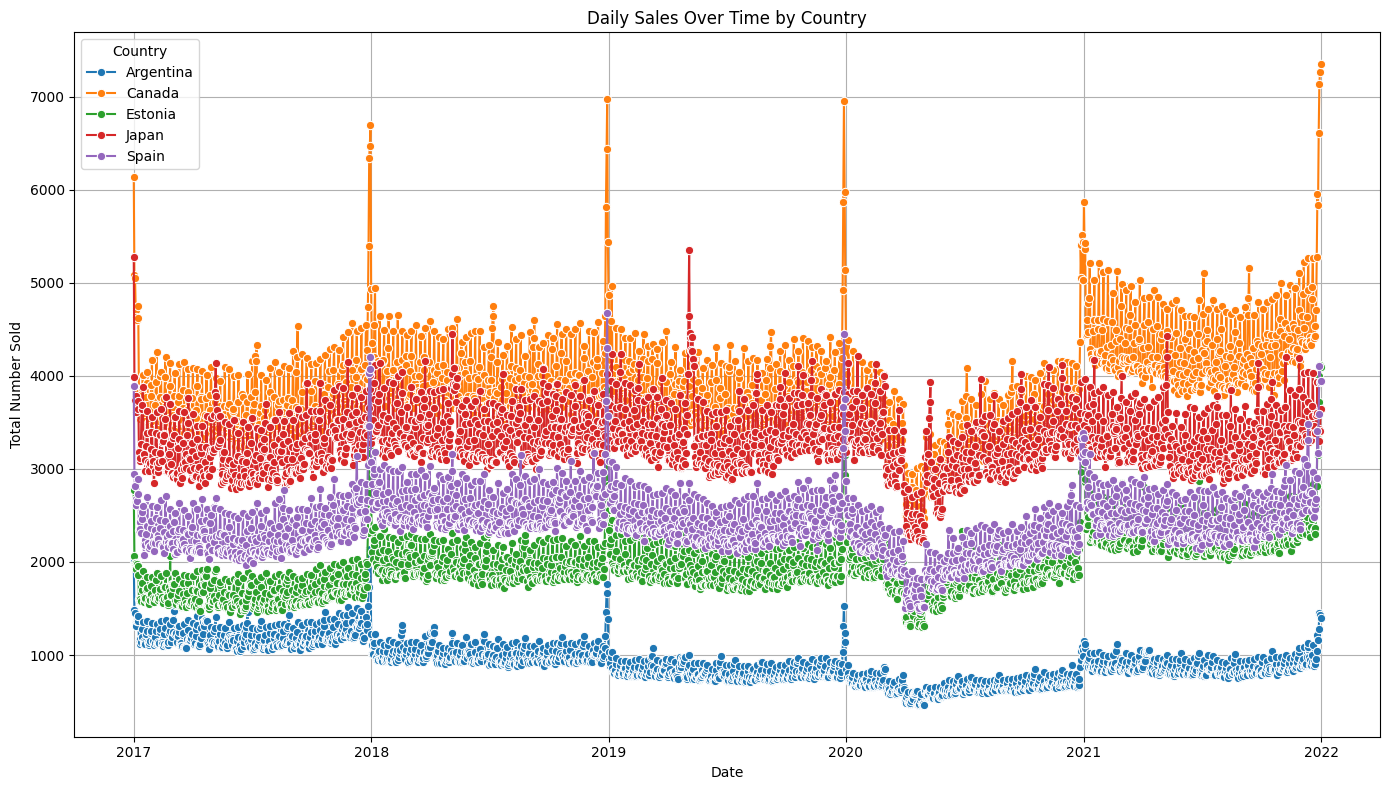

In [198]:
daily_sales_per_country = data.groupby(['date', 'country'])['num_sold'].sum().reset_index()
plt.figure(figsize=(14, 8))
sns.lineplot(data=daily_sales_per_country, x='date', y='num_sold', hue='country', marker='o')

plt.title('Daily Sales Over Time by Country')
plt.xlabel('Date')
plt.ylabel('Total Number Sold')
plt.legend(title='Country', loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

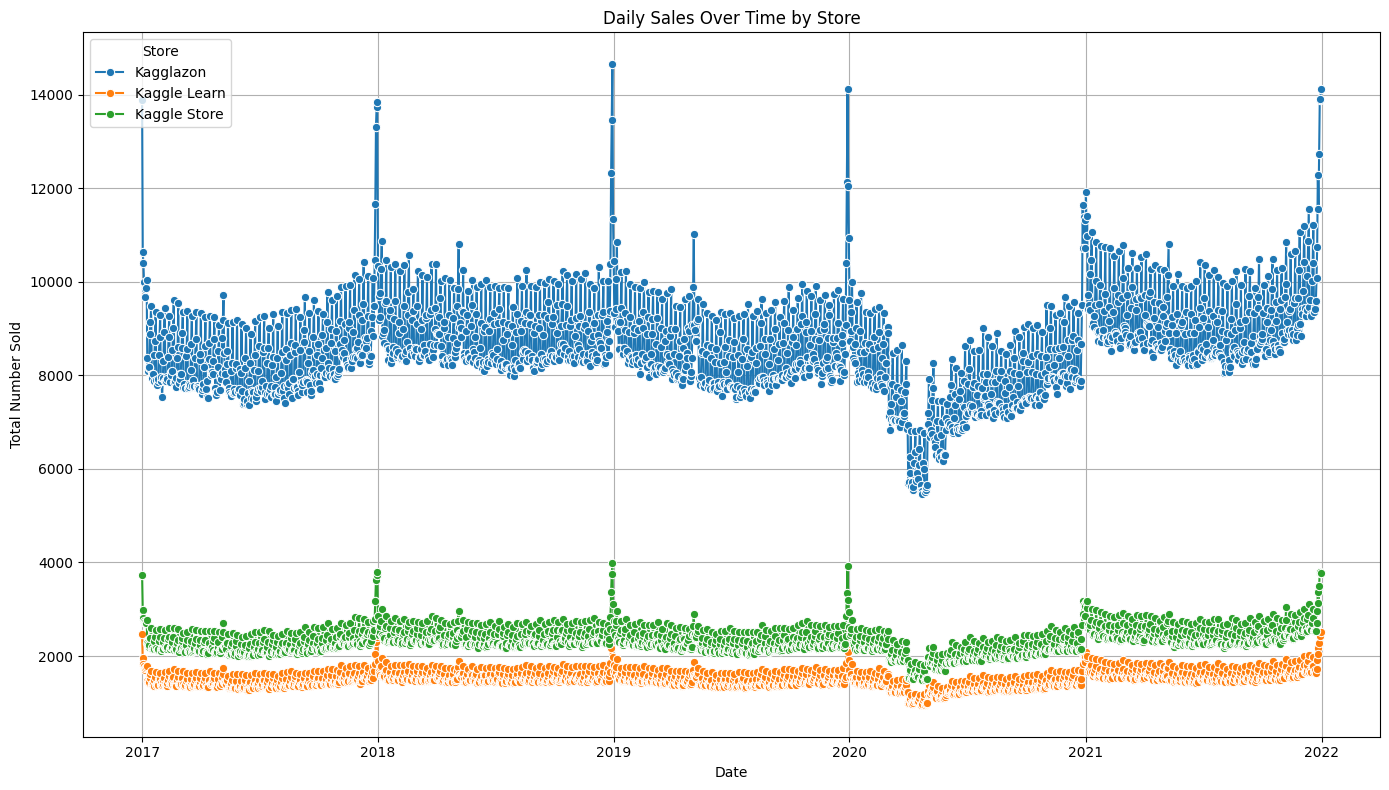

In [199]:
daily_sales_per_store = data.groupby(['date', 'store'])['num_sold'].sum().reset_index()

plt.figure(figsize=(14, 8))

sns.lineplot(data=daily_sales_per_store, x='date', y='num_sold', hue='store', marker='o')

plt.title('Daily Sales Over Time by Store')
plt.xlabel('Date')
plt.ylabel('Total Number Sold')
plt.legend(title='Store', loc='upper left')
plt.grid()
plt.tight_layout()
plt.show()

                                          product  num_sold
0               Using LLMs to Improve Your Coding   6069281
1                   Using LLMs to Train More LLMs   5993975
3      Using LLMs to Win More Kaggle Competitions   5068313
4                      Using LLMs to Write Better   4604192
2  Using LLMs to Win Friends and Influence People    932564


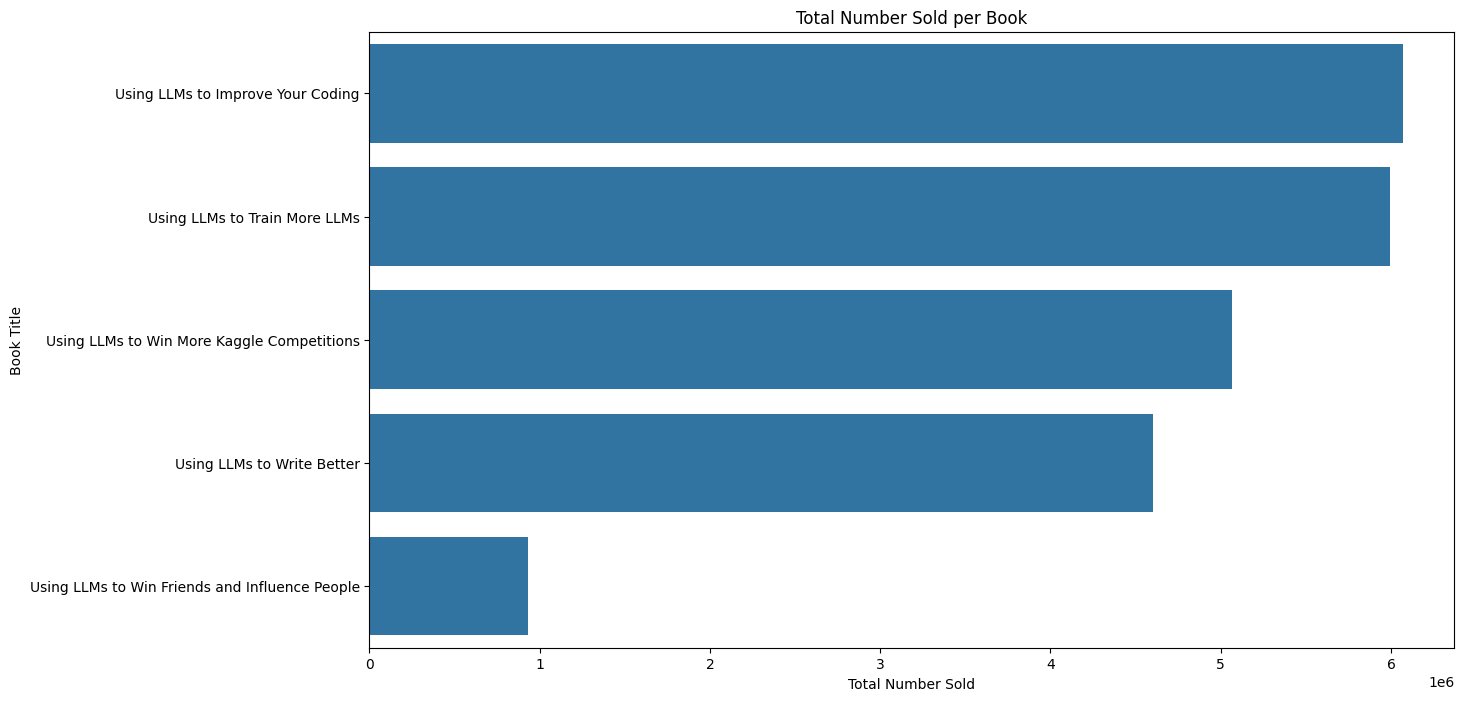

In [200]:
total_sold_per_book = data.groupby('product')['num_sold'].sum().reset_index()

total_sold_per_book = total_sold_per_book.sort_values(by='num_sold', ascending=False)

print(total_sold_per_book)

plt.figure(figsize=(14, 8))
sns.barplot(x='num_sold', y='product', data=total_sold_per_book)
plt.title('Total Number Sold per Book')
plt.xlabel('Total Number Sold')
plt.ylabel('Book Title')
plt.show()

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/statsmodels/tsa/deterministic.py:569: FutureWarning: 'A' is deprecated and will be removed in a future version, please use 'YE' instead.
  index = pd.date_range("2020-01-01", freq=freq, periods=1)


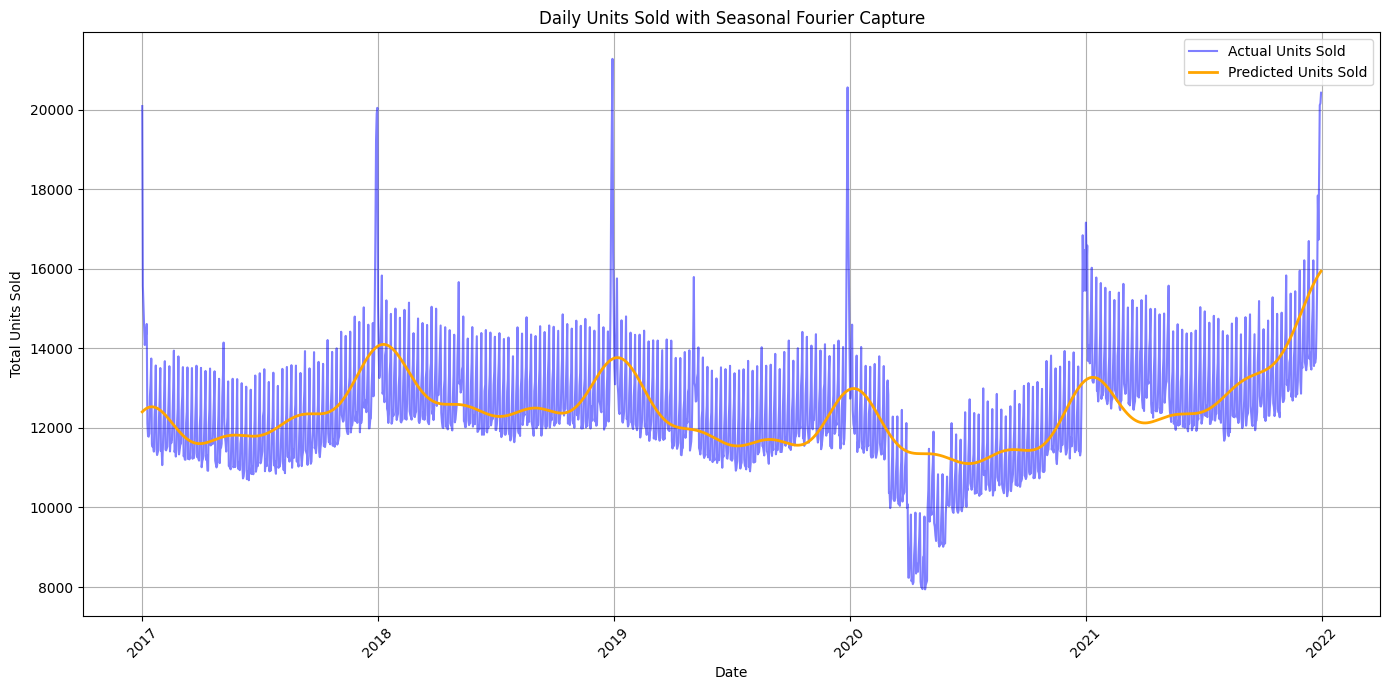

In [205]:
daily_sales_summary = data.groupby('date')['num_sold'].sum().reset_index()

fourier_terms = CalendarFourier(freq='A', order=3)  
deterministic_process = DeterministicProcess(
    index=daily_sales_summary['date'],
    constant=False,
    order=3,
    additional_terms=[fourier_terms],
    drop=True,
)

design_matrix = deterministic_process.in_sample()
target_variable = daily_sales_summary['num_sold']

daily_sales_summary.reset_index(drop=True, inplace=True)
design_matrix.reset_index(drop=True, inplace=True)

linear_model = LinearRegression()
linear_model.fit(design_matrix, target_variable)

daily_sales_summary['predicted_units'] = linear_model.predict(design_matrix)

plt.figure(figsize=(14, 7))
plt.plot(daily_sales_summary['date'], daily_sales_summary['num_sold'], label='Actual Units Sold', color='blue', alpha=0.5)
plt.plot(daily_sales_summary['date'], daily_sales_summary['predicted_units'], label='Predicted Units Sold', color='orange', linewidth=2)
plt.title('Daily Units Sold with Seasonal Fourier Capture')
plt.xlabel('Date')
plt.ylabel('Total Units Sold')
plt.legend()
plt.xticks(rotation=45)
plt.grid()
plt.tight_layout()
plt.show()